# updates
* v 0.02
    * Изменена транслитерация для sirena_exp, используется iuliia
    * Для отсеивания в финальном фрейме людей с похожим написанием имён применяется алгоритм на основе пересечения с самим собой и похожести написания имени на основе расстояние Левенштейна
    * Добавлено количество людей в явном виде, и их список 

Предобработка данных, которая проводилась в питоне и не потерялась в процессе работы :) в colab https://colab.research.google.com/drive/1d6f4eabNxPgIauZlZeLXPUFUpXqQ0cFT?usp=sharing


# Настройка окружения

## Установка пакетов

In [ ]:
!pip install iuliia
!pip install python-Levenshtein

     |████████████████████████████████| 51kB 2.9MB/s 
  Created wheel for python-Levenshtein: filename=python_Levenshtein-0.12.2-cp37-cp37m-linux_x86_64.whl size=149812 sha256=e3b7652e4845d404fbd9aefc82b686ee3f262ea85bd69ada248759d0c92402e7
  Stored in directory: /root/.cache/pip/wheels/b3/26/73/4b48503bac73f01cf18e52cd250947049a7f339e940c5df8fc
Successfully built python-Levenshtein


## Импорт пакетов

In [ ]:
from sklearn import preprocessing

import pandas as pd
import numpy as np
import datetime

import Levenshtein
import iuliia

## Авторизация в GoogleDrive для доступа к файлам

In [ ]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Изучение данных

## Загрузка данных

In [ ]:
files = {
    'BoardingData.csv': '1tsdyieiuvd2_soYZfnWf2KwYfiNfZ5bG',
    'FrequentFlyerForum-Profiles.csv': '1CBX6r-cSBOUSYPXBMBB6H5kus8XgTR3-',
    'PointzAggregator-AirlinesData.csv': '1GUsw71571ig01-iCF9zEFs1cn5jeKCoB',
    'Sirena-export-fixed.csv': '1eWau_Fw_Mj2CPOUPnIsM4xiBJZWoii2Y',
    'SkyTeam-Exchange.csv': '1qkRaGOSXuuQcCe9yWpKeCSrWgS_qmXL-',
    'YourBoardingPassDotAero.csv': '18VNEEMYATrE9Exn12TWBpAdQKUFTquC6',
    'Skyteam_Timetable.csv': '1pjjBdW-F_Tn9PVsmwgaFdhXrXOaG5f_e',
    'res.csv': '1zxDmHolxe67Y1xPST5h20IVan-sU_jEN',
}
for file in files:    
    downloaded = drive.CreateFile({'id': files[file]})
    downloaded.GetContentFile(file)

In [ ]:
board_data_df = pd.read_csv('BoardingData.csv', sep=';')
freq_flyer_df = pd.read_csv('FrequentFlyerForum-Profiles.csv')
point_agg_df = pd.read_csv('PointzAggregator-AirlinesData.csv')
sirena_exp_df = pd.read_csv('Sirena-export-fixed.csv')
sk_exchange_df = pd.read_csv('SkyTeam-Exchange.csv')
board_pass_df = pd.read_csv('YourBoardingPassDotAero.csv')
sk_timetable_df = pd.read_csv('Skyteam_Timetable.csv')

## Просмотр данных

### Первые строки

In [ ]:
board_data_df.head()

,PassengerFirstName,PassengerSecondName,PassengerLastName,PassengerSex,PassengerBirthDate,PassengerDocument,BookingCode,TicketNumber,Baggage,FlightDate,FlightTime,FlightNumber,CodeShare,Destination
0,SAVELII,VIKTOROVICH,RUSANOV,Male,03/10/1983,2879 096860,FRNINO,6625956945991971,Transit,2017-03-22,06:05,SU1369,Own,Moscow
1,LEV,MARKOVICH,ISAEV,Male,12/13/1975,1788 173211,Not presented,1643715499224676,Registered,2017-03-18,22:10,SU1180,Own,Volgograd
2,NIKOLAI,I.,NIKOLSKII,Male,12/26/1990,4396 926588,VWNYGF,6247422701565929,Transit,2017-03-18,22:10,SU1180,Own,Volgograd
3,ANATOLII,PETROVICH,SHILOV,Male,05/24/1997,2595 919752,WQFFUE,Not presented,Registered,2017-03-18,22:10,SU1180,Own,Volgograd
4,MIROSLAVA,VIACHESLAVOVNA,SEMENOVA,Female,01/31/1976,6775 516990,Not presented,Not presented,Registered,2017-03-12,11:45,SU6284,Own,Moscow


In [ ]:
freq_flyer_df.head()

,Unnamed: 0,NickName,Arrival_Airport,Arrival_City,Arrival_Country,Departure_Airport,Departure_City,Departure_Country,Date,Codeshare,Flight,Sex,First Name,Last Name
0,0,0,PIT,Pittsburgh PA,United States of,BOS,Boston MA,United States of,2017-03-04,False,DL3377,Male,NaN,NaN
1,1,0,DTW,Detroit MI,United States of,GRB,Green Bay WI,United States of,2017-07-21,False,DL3630,Male,NaN,NaN
2,2,0,LGA,New York NY,United States of,PIT,Pittsburgh PA,United States of,2017-03-22,False,DL5361,Male,NaN,NaN
3,3,0,WAW,Warsaw,Poland,SVO,Moscow,Russian Federation,2017-01-04,True,SU3702,Male,NaN,NaN
4,4,0,ATL,Atlanta GA,United States of,XNA,Fayetteville AR,United States of,2017-08-08,False,DL3412,Male,NaN,NaN


In [ ]:
point_agg_df.head()

,uid,first_name,last_name,cards_type,cards_number,bonus_program,activity_code,activity_date,activity_departure,activity_arrival,activity_fare
0,613142142,IAROMIR,ZVEREV,Airlines,FB 171388778,Flying Blue,KE827,2017-08-06,rea,SZX,YGRPZT
1,613142142,IAROMIR,ZVEREV,Airlines,FB 171388778,Flying Blue,MU9706,2017-10-26,PEK,BSD,YSTNYV
2,103197717,VITALINA,KOROVINA,Airlines,KE 696768759,Korean Air SKYPASS,DL5058,2017-09-11,CHA,ATL,YRSTKY
3,103197717,VITALINA,KOROVINA,Airlines,KE 696768759,Korean Air SKYPASS,KE1,2017-04-01,rea,HNL,PRSTRU
4,103197717,VITALINA,KOROVINA,Airlines,KE 696768759,Korean Air SKYPASS,DL837,2017-09-13,ATL,HNL,YGRPNG


In [ ]:
sirena_exp_df.head()

,Unnamed: 0,PaxName,PaxBirthDa,teDepartDate,DepartTime,ArrivalDate,ArrivalTime,FlightCod,eShFrom,Dest,Code e-Ticket,Trav,elDoc,Seat,Meal,Trv,ClsFare Baggage,PaxAdditionalInfo,Unnamed: 17,Unnamed: 18,AgentInfo
0,0,ОЗЕРОВ ИЛЬДАР ДАНИИЛОВИЧ,15.05.1999,30.05.2017,0:05,30.05.2017,8:05,SU1306NO,SVO,OVB,ZBQSPY7360415302044672,9375,53270,NaN,NaN,J,JGRPGN0PC,S,FF#SU,38116280.0,Go2See
1,1,КОЛОСОВ САМИР ТАМЕРЛАНОВИЧ,NaN,27.12.2017,2:15,27.12.2017,4:40,SU1323NO,MMK,SVO,MHPBBX7398421117936516,2244,645520,NaN,KSML,Y,YRSTUQ,9,FF#FB,284903754.0,NaN
2,2,ИГНАТОВА СНЕЖАНА КОНСТАНТИНОВНА,NaN,19.09.2017,6:40,19.09.2017,7:45,SU1481NO,KJA,SVO,REDLVB5174973140468001,8115,961316,NaN,NaN,Y,YSTNJL,F,NaN,NaN,KupiBilet
3,3,ЖАРОВ ПЛАТОН АЛЬБЕРТОВИЧ,02.05.1999,18.03.2017,22:10,19.03.2017,1:05,SU1180NO,SVO,VOG,NSJNGQ5274206497242737,98 6,865148,NaN,NaN,J,JFLXLS0PC,#,FF#FB,884556993.0,Travelgenio
4,4,НИКОЛЬСКИЙ НИКОЛАЙ ИГОРЕВИЧ,26.12.1990,18.03.2017,22:10,19.03.2017,1:05,SU1180NO,SVO,VOG,VWNYGF6247422701565929,4396,926588,NaN,NaN,Y,YFLXPG,NaN,FF#SU,183142068.0,OZON.travel


In [ ]:
sk_exchange_df.head()

,Unnamed: 0,card,date,flight,from,to,status,class,fare
0,0,FB 520518073,2017-01-01,AF1145,SVO,CDG,LANDED,Y,YRSTFN
1,1,FB 18427809,2017-01-01,AF1844,SVO,CDG,LANDED,Y,YGRPZR
2,2,KE 993927664,2017-01-01,AF4855,SVO,CDG,LANDED,Y,YRSTJQ
3,3,SU 789402704,2017-01-01,AF4901,SVO,CDG,LANDED,Y,YGRPAT
4,4,KE 352734424,2017-01-01,AZ545,SVO,FCO,LANDED,Y,YFLXKO


In [ ]:
board_pass_df.head()

,Unnamed: 0,sequence,gender,name,fare,flightNumber,cityFrom,cityTo,gate,airportFrom,airportTo,date,time,share,seat,PNR,ticket
0,0,29,MRS,MADINA SHIRYAEVA,Y,CZ6625,ZHENGZHOU,XINZHOU,NaN,CGO,WUT,2017-09-22,14:50,Operated by Some Other Airline,NaN,OQQOHE,2669364900304337
1,1,75,MRS,ALINA SUKHANOVA,Y,SV1481,RIYADH,QAISUMAH,NaN,RUH,AQI,2017-09-22,05:10,Operated by Some Other Airline,NaN,ZLMHOE,9161977196434544
2,2,42,MR,LEV GONCHAROV,Y,SU2314,MOSCOW,BERLIN,NaN,SVO,SXF,2017-09-22,14:30,Operated by Some Other Airline,NaN,KYWCAX,3154693033418596
3,3,100,MRS,KULAGINA AMINA,Y,SU1175,ASTRAKHAN,MOSCOW,NaN,ASF,SVO,2017-09-22,19:50,Operated by Some Other Airline,NaN,QMQCLS,5632976945423178
4,4,6,MR,OLEYNIKOV VLADIMIR,Y,AZ715,ATHENS,ROME,NaN,ATH,FCO,2017-09-22,13:15,Operated by Some Other Airline,NaN,DOUZUE,8399241805063994


In [ ]:
sk_timetable_df.head()

,Unnamed: 0,Unnamed: 0.1,Validity,Days,Dep_Time,Arr_Time,Flight,Aircraft,Travel_Time,city_from,country_from,airport_from,city_to,country_to,airport_to
0,0,0,01 Nov - 31 Jan,1234567,06:00,07:25,KL1328,73W,1H25M,Aalborg,Denmark,AA,Amsterdam,Netherlands,AMS
1,1,1,01 Nov - 31 Jan,1234567,12:10,13:35,KL1334,73W,1H25M,Aalborg,Denmark,AA,Amsterdam,Netherlands,AMS
2,2,2,01 Nov - 23 Dec,1234567,18:15,19:35,KL1336,EQV,1H20M,Aalborg,Denmark,AA,Amsterdam,Netherlands,AMS
3,3,3,26 Dec - 06 Jan,1 34567,18:15,19:35,KL1336,EQV,1H20M,Aalborg,Denmark,AA,Amsterdam,Netherlands,AMS
4,4,4,07 Jan - 31 Jan,1234567,18:15,19:35,KL1336,EQV,1H20M,Aalborg,Denmark,AA,Amsterdam,Netherlands,AMS


# Предобработка

### Отсечение фиктивных столбцов после предобработки

In [ ]:
freq_flyer_df.drop(columns=['Unnamed: 0'], inplace=True)
sirena_exp_df.drop(columns=['Unnamed: 0'], inplace=True)
sk_exchange_df.drop(columns=['Unnamed: 0'], inplace=True)
board_pass_df.drop(columns=['Unnamed: 0'], inplace=True)
sk_timetable_df.drop(columns=['Unnamed: 0', 'Unnamed: 0.1'], inplace=True)

### Преобразование столбцов в формат даты

In [ ]:
board_data_df['FlightDateTime'] = pd.to_datetime(board_data_df['FlightDate'] + ' ' + board_data_df['FlightTime'])
# board_data_df.drop(columns=['FlightDate', 'FlightTime'], inplace=True)  # удаление исходных после слияния

freq_flyer_df.Date = pd.to_datetime(freq_flyer_df.Date)

point_agg_df.activity_date = pd.to_datetime(point_agg_df.activity_date)

sirena_exp_df.PaxBirthDa = pd.to_datetime(sirena_exp_df.PaxBirthDa)
sirena_exp_df['DepartDateTime'] = pd.to_datetime(sirena_exp_df['teDepartDate'] + ' ' + sirena_exp_df['DepartTime'])
sirena_exp_df['ArrivalDateTime'] = pd.to_datetime(sirena_exp_df['ArrivalDate'] + ' ' + sirena_exp_df['ArrivalTime'])
# происходило слияние даты и времени в один столбец, удаляются исходные
# sirena_exp_df.drop(columns=['teDepartDate', 'DepartTime', 'ArrivalDate', 'ArrivalTime'], inplace=True)

sk_exchange_df.date = pd.to_datetime(sk_exchange_df.date)

board_pass_df['BoardDateTime'] = pd.to_datetime(board_pass_df['date'] + ' ' + board_pass_df['time'])
board_pass_df['date'] = pd.to_datetime(board_pass_df['date'])

### Sirena_exp 
* Преобразования столбца в столбец карты
* Удаления столбца без данных (Seat)

In [ ]:
sirena_exp_df.head()  # PaxName нужно преобразовать в транслит

,PaxName,PaxBirthDa,teDepartDate,DepartTime,ArrivalDate,ArrivalTime,FlightCod,eShFrom,Dest,Code e-Ticket,Trav,elDoc,Seat,Meal,Trv,ClsFare Baggage,PaxAdditionalInfo,Unnamed: 17,Unnamed: 18,AgentInfo,DepartDateTime,ArrivalDateTime
0,ОЗЕРОВ ИЛЬДАР ДАНИИЛОВИЧ,1999-05-15,30.05.2017,0:05,30.05.2017,8:05,SU1306NO,SVO,OVB,ZBQSPY7360415302044672,9375,53270,NaN,NaN,J,JGRPGN0PC,S,FF#SU,38116280.0,Go2See,2017-05-30 00:05:00,2017-05-30 08:05:00
1,КОЛОСОВ САМИР ТАМЕРЛАНОВИЧ,NaT,27.12.2017,2:15,27.12.2017,4:40,SU1323NO,MMK,SVO,MHPBBX7398421117936516,2244,645520,NaN,KSML,Y,YRSTUQ,9,FF#FB,284903754.0,NaN,2017-12-27 02:15:00,2017-12-27 04:40:00
2,ИГНАТОВА СНЕЖАНА КОНСТАНТИНОВНА,NaT,19.09.2017,6:40,19.09.2017,7:45,SU1481NO,KJA,SVO,REDLVB5174973140468001,8115,961316,NaN,NaN,Y,YSTNJL,F,NaN,NaN,KupiBilet,2017-09-19 06:40:00,2017-09-19 07:45:00
3,ЖАРОВ ПЛАТОН АЛЬБЕРТОВИЧ,1999-02-05,18.03.2017,22:10,19.03.2017,1:05,SU1180NO,SVO,VOG,NSJNGQ5274206497242737,98 6,865148,NaN,NaN,J,JFLXLS0PC,#,FF#FB,884556993.0,Travelgenio,2017-03-18 22:10:00,2017-03-19 01:05:00
4,НИКОЛЬСКИЙ НИКОЛАЙ ИГОРЕВИЧ,1990-12-26,18.03.2017,22:10,19.03.2017,1:05,SU1180NO,SVO,VOG,VWNYGF6247422701565929,4396,926588,NaN,NaN,Y,YFLXPG,NaN,FF#SU,183142068.0,OZON.travel,2017-03-18 22:10:00,2017-03-19 01:05:00


In [ ]:
sirena_exp_df.Seat.unique()  # лишний столбец нет уникальных значений

array([nan])

In [ ]:
# в Unnamed: 17 и Unnamed: 18 лежат серия и номер карты лояльности
cards = []
for _, row in sirena_exp_df.iterrows():
    if type(row['Unnamed: 17']) is str:
        cards.append(f'{row["Unnamed: 17"][:2]} {int(row["Unnamed: 18"])}')
    else:
        cards.append(None)

In [ ]:
sirena_exp_df = sirena_exp_df.assign(card=cards)
sirena_exp_df.drop(columns=['Unnamed: 17', 'Unnamed: 18', 'Seat'], inplace=True)

По номерам карт не совпадает ни с sk_exchange ни с point_agg

### Транслитерация sirena_exp_df

In [ ]:
sirena_exp_df['PaxName'] = sirena_exp_df['PaxName'].apply(iuliia.translate, schema=iuliia.GOST_779_ALT).str.upper().apply(lambda x: ' '.join(x.split()[-2::-1]))

In [ ]:
sirena_exp_df.head()

,PaxName,PaxBirthDa,teDepartDate,DepartTime,ArrivalDate,ArrivalTime,FlightCod,eShFrom,Dest,Code e-Ticket,Trav,elDoc,Meal,Trv,ClsFare Baggage,PaxAdditionalInfo,AgentInfo,DepartDateTime,ArrivalDateTime,card
0,IL`DAR OZEROV,1999-05-15,30.05.2017,0:05,30.05.2017,8:05,SU1306NO,SVO,OVB,ZBQSPY7360415302044672,9375,53270,NaN,J,JGRPGN0PC,S,Go2See,2017-05-30 00:05:00,2017-05-30 08:05:00,FF 38116280
1,SAMIR KOLOSOV,NaT,27.12.2017,2:15,27.12.2017,4:40,SU1323NO,MMK,SVO,MHPBBX7398421117936516,2244,645520,KSML,Y,YRSTUQ,9,NaN,2017-12-27 02:15:00,2017-12-27 04:40:00,FF 284903754
2,SNEZHANA IGNATOVA,NaT,19.09.2017,6:40,19.09.2017,7:45,SU1481NO,KJA,SVO,REDLVB5174973140468001,8115,961316,NaN,Y,YSTNJL,F,KupiBilet,2017-09-19 06:40:00,2017-09-19 07:45:00,None
3,PLATON ZHAROV,1999-02-05,18.03.2017,22:10,19.03.2017,1:05,SU1180NO,SVO,VOG,NSJNGQ5274206497242737,98 6,865148,NaN,J,JFLXLS0PC,#,Travelgenio,2017-03-18 22:10:00,2017-03-19 01:05:00,FF 884556993
4,NIKOLAJ NIKOL`SKIJ,1990-12-26,18.03.2017,22:10,19.03.2017,1:05,SU1180NO,SVO,VOG,VWNYGF6247422701565929,4396,926588,NaN,Y,YFLXPG,NaN,OZON.travel,2017-03-18 22:10:00,2017-03-19 01:05:00,FF 183142068


### Дополнение sk_exchange именами

In [ ]:
sk_exchange_with_names_df = sk_exchange_df.merge(point_agg_df[['first_name', 'last_name', 'cards_number']],
                                                 how='left',
                                                 left_on='card',
                                                 right_on='cards_number').drop_duplicates()
sk_exchange_with_names_df.drop(columns=['cards_number'], inplace=True)

In [ ]:
sk_exchange_with_names_df.head()

,card,date,flight,from,to,status,class,fare,first_name,last_name
0,FB 520518073,2017-01-01,AF1145,SVO,CDG,LANDED,Y,YRSTFN,MELANIIA,AFANASEVA
6,FB 18427809,2017-01-01,AF1844,SVO,CDG,LANDED,Y,YGRPZR,SOFIA,MASLOVA
14,KE 993927664,2017-01-01,AF4855,SVO,CDG,LANDED,Y,YRSTJQ,NaN,NaN
15,SU 789402704,2017-01-01,AF4901,SVO,CDG,LANDED,Y,YGRPAT,BORIS,MALININ
19,KE 352734424,2017-01-01,AZ545,SVO,FCO,LANDED,Y,YFLXKO,FEDOR,ROGOV


Board_pass

### board_pass_df
* Удаление столбцов без данных (Seat, gate)

In [ ]:
board_pass_df.drop(columns=['seat', 'gate'], inplace=True)
board_pass_df.head()

,sequence,gender,name,fare,flightNumber,cityFrom,cityTo,airportFrom,airportTo,date,time,share,PNR,ticket,BoardDateTime
0,29,MRS,MADINA SHIRYAEVA,Y,CZ6625,ZHENGZHOU,XINZHOU,CGO,WUT,2017-09-22,14:50,Operated by Some Other Airline,OQQOHE,2669364900304337,2017-09-22 14:50:00
1,75,MRS,ALINA SUKHANOVA,Y,SV1481,RIYADH,QAISUMAH,RUH,AQI,2017-09-22,05:10,Operated by Some Other Airline,ZLMHOE,9161977196434544,2017-09-22 05:10:00
2,42,MR,LEV GONCHAROV,Y,SU2314,MOSCOW,BERLIN,SVO,SXF,2017-09-22,14:30,Operated by Some Other Airline,KYWCAX,3154693033418596,2017-09-22 14:30:00
3,100,MRS,KULAGINA AMINA,Y,SU1175,ASTRAKHAN,MOSCOW,ASF,SVO,2017-09-22,19:50,Operated by Some Other Airline,QMQCLS,5632976945423178,2017-09-22 19:50:00
4,6,MR,OLEYNIKOV VLADIMIR,Y,AZ715,ATHENS,ROME,ATH,FCO,2017-09-22,13:15,Operated by Some Other Airline,DOUZUE,8399241805063994,2017-09-22 13:15:00


# Объединение фреймов

#### список полей для объединения
* имя -- name только Имя Фамилия
* дата полёта -- date
* номер самолёта -- flight_number
* fare
* аэропорт вылета
* аэропорт посадки
* город вылета
* город посадки

#### Переименовывание столбцов

In [ ]:
board_data_df['name'] = board_data_df.PassengerFirstName + ' ' + board_data_df.PassengerLastName
board_data_concat_df = board_data_df[['name', 'FlightDate', 'FlightNumber', 'Destination']].rename(columns={
    'FlightDateTime': 'date',
    'FlightNumber': 'flight_number',
    'Destination': 'city_to',
})

In [ ]:
board_pass_concat_df = board_pass_df[['name', 'fare','cityFrom', 'cityTo', 'airportFrom', 'airportTo', 'BoardDateTime']].rename(columns={
                            'cityFrom' : 'city_from',
                            'cityTo':'city_to',
                            'airportFrom': 'airport_from',
                            'airportTo': 'airport_to',
                            'BoardDateTime': 'date',
                        })
board_pass_concat_df['name'] = board_pass_concat_df['name'].str.replace("'", '')

In [ ]:
freq_flyer_concat_df = freq_flyer_df.rename(columns={'Arrival_Airport': 'airport_to',
                              'Arrival_City': 'city_to',
                              'Departure_Airport': 'airport_from',
                              'Departure_City': 'city_from',
                              'Date':'date',
                              'Flight': 'flight_number'})
freq_flyer_concat_df['name'] = freq_flyer_df['First Name'] + ' ' + freq_flyer_df['Last Name']
freq_flyer_concat_df['name'] = freq_flyer_concat_df['name'].str.replace("'", '')
freq_flyer_concat_df = freq_flyer_concat_df[['name', 'airport_from', 'city_from', 'airport_to', 'city_to', 'date', 'flight_number']]
freq_flyer_concat_df = freq_flyer_concat_df.dropna()

In [ ]:
point_agg_concat_df = point_agg_df.assign(name = point_agg_df['first_name'].str.replace("'", '') +
                                          ' ' +
                                          point_agg_df['last_name'].str.replace("'", ''))
point_agg_concat_df.rename(columns={'activity_date': 'date',
                                    'activity_departure': 'airport_from',
                                    'activity_arrival': 'airport_to',
                                    'activity_fare': 'fare'},
                           inplace=True)
point_agg_concat_df = point_agg_concat_df[['name', 'airport_from', 'airport_to', 'date','fare']]

In [ ]:
sirena_bez_apostr = sirena_exp_df.assign(name = sirena_exp_df['PaxName'].str.replace("`", ''))
sirena_exp_concat_df = sirena_bez_apostr.rename(columns={
        'DepartDateTime': 'date',
        'Dest': 'airport_to',
        'eShFrom': 'airport_from',
    })
sirena_exp_concat_df = sirena_exp_concat_df[['name', 'airport_from', 'airport_to', 'date']]

In [ ]:
sk_exchange_concat_df = sk_exchange_with_names_df.rename(columns={
    'flight': 'flight_number',
    'from': 'airport_from',
    'to': 'airport_to', 
})
sk_exchange_concat_df['name'] = sk_exchange_concat_df['first_name'] + ' ' + sk_exchange_concat_df['last_name']
sk_exchange_concat_df['name'] = sk_exchange_concat_df['name'].str.replace("'", '')
sk_exchange_concat_df = sk_exchange_concat_df[['date', 'name','airport_to', 'airport_from', 'fare' ]]

#### Конкатенация

In [ ]:
res_df = pd.concat([
           board_data_concat_df,
           board_pass_concat_df,
           freq_flyer_concat_df,
           point_agg_concat_df,
           sirena_exp_concat_df,
           sk_exchange_concat_df,])
res_df = res_df[['name', 'date', 'flight_number',
        'city_from',
        'airport_from',
        'city_to',
        'airport_to',
        'fare'
        ]]

In [ ]:
res_df.head()

,name,date,flight_number,city_from,airport_from,city_to,airport_to,fare
0,SAVELII RUSANOV,NaT,SU1369,NaN,NaN,Moscow,NaN,NaN
1,LEV ISAEV,NaT,SU1180,NaN,NaN,Volgograd,NaN,NaN
2,NIKOLAI NIKOLSKII,NaT,SU1180,NaN,NaN,Volgograd,NaN,NaN
3,ANATOLII SHILOV,NaT,SU1180,NaN,NaN,Volgograd,NaN,NaN
4,MIROSLAVA SEMENOVA,NaT,SU6284,NaN,NaN,Moscow,NaN,NaN


In [ ]:
downloaded = drive.CreateFile({'id': '1zxDmHolxe67Y1xPST5h20IVan-sU_jEN'})
downloaded.GetContentFile('res.csv')

In [ ]:
res_df.to_csv('res.csv')

In [ ]:
uploaded = drive.CreateFile({'title': 'res.csv', 'parents': ['1t02NJlk6b_k8djN2l9nCPt0U1AKjypxu']})
uploaded.SetContentFile('res.csv')
uploaded.Upload()

# Исследование общего фрейма

In [ ]:
res_df = pd.read_csv('res.csv')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (2,3,4,5,6,7,8) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
res_df.drop(columns=['Unnamed: 0'], inplace=True)
res_df = res_df.drop_duplicates()
res_df = res_df.dropna(subset=['name'])
res_df['date'] = pd.to_datetime(res_df.date)

In [ ]:
res_df.head()

,name,date,flight_number,city_from,airport_from,city_to,airport_to,fare
0,SAVELII RUSANOV,NaT,SU1369,NaN,NaN,Moscow,NaN,NaN
1,LEV ISAEV,NaT,SU1180,NaN,NaN,Volgograd,NaN,NaN
2,NIKOLAI NIKOLSKII,NaT,SU1180,NaN,NaN,Volgograd,NaN,NaN
3,ANATOLII SHILOV,NaT,SU1180,NaN,NaN,Volgograd,NaN,NaN
4,MIROSLAVA SEMENOVA,NaT,SU6284,NaN,NaN,Moscow,NaN,NaN


### Обработка людей с летавших из Москвы в Москву

In [ ]:
from_msc_df = res_df[(res_df.city_from == 'Moscow') | (res_df.airport_from.isin(['SVO', 'VKO', 'DME']))]
to_msc_df = res_df[(res_df.city_to == 'Moscow') | (res_df.airport_to.isin(['SVO', 'VKO', 'DME']))]

In [ ]:
msc_df = pd.concat([from_msc_df, to_msc_df])
msc_visiters_df = res_df[(res_df.name.isin(from_msc_df.name) & res_df.name.isin(to_msc_df.name))]

In [ ]:
msc_visiters_df.head()

,name,date,flight_number,city_from,airport_from,city_to,airport_to,fare
0,SAVELII RUSANOV,NaT,SU1369,NaN,NaN,Moscow,NaN,NaN
1,LEV ISAEV,NaT,SU1180,NaN,NaN,Volgograd,NaN,NaN
2,NIKOLAI NIKOLSKII,NaT,SU1180,NaN,NaN,Volgograd,NaN,NaN
4,MIROSLAVA SEMENOVA,NaT,SU6284,NaN,NaN,Moscow,NaN,NaN
5,ARTEM KAPUSTIN,NaT,SU6284,NaN,NaN,Moscow,NaN,NaN


In [ ]:
msc_df.sort_values(by=['date', 'airport_from'])

,name,date,flight_number,city_from,airport_from,city_to,airport_to,fare
1610626,MARAT BIRJUKOV,01.01.2017,NaN,NaN,AAQ,NaN,SVO,NaN
1610627,ALEKSANDRA OVSJANNIKOVA,01.01.2017,NaN,NaN,AAQ,NaN,SVO,NaN
1610628,LJUBOV RUSANOVA,01.01.2017,NaN,NaN,AAQ,NaN,SVO,NaN
1610630,INNA ZHILINA,01.01.2017,NaN,NaN,AAQ,NaN,SVO,NaN
1610632,OLEG SELIVANOV,01.01.2017,NaN,NaN,AAQ,NaN,SVO,NaN
...,...,...,...,...,...,...,...,...
1672352,VASILINA NOVIKOVA,31.12.2017,NaN,NaN,SVX,NaN,SVO,NaN
1678834,ELIZAVETA LATYSHEVA,31.12.2017,NaN,NaN,SVX,NaN,SVO,NaN
1678835,ALBINA POLIKARPOVA,31.12.2017,NaN,NaN,SVX,NaN,SVO,NaN
1690894,AGATA KIREEVA,31.12.2017,NaN,NaN,UFA,NaN,SVO,NaN


## Отсеивание тех, кто мало летал

In [ ]:
import matplotlib.pyplot as plt

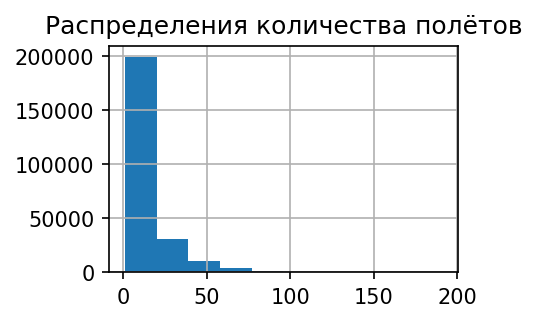

In [ ]:
plt.figure(figsize=(3,2), dpi=150)
plt.title('Распределения количества полётов')
res_df.fillna(value=datetime.datetime(year=2007, month=1, day=1)).groupby('name').agg({'date' : 'count'}).date.hist()

На основании интуиции и данного распределения количества полётов решили взять в качестве порого 50

In [ ]:
temp_df = msc_visiters_df.groupby('name').count().sort_values(by='date')

filt_msc_visiters_df = msc_visiters_df[msc_visiters_df.name.isin(temp_df[temp_df['date'] > 50].index)]
print(f'Количство полётов часто летающих людей: {len(filt_msc_visiters_df)}')

Количство полётов часто летающих людей: 558615


In [ ]:
suspicious_people = set(filt_msc_visiters_df.name.unique())
print(f'Количество часто летающих: {len(suspicious_people)}')

Количество часто летающих: 7835


In [ ]:
suspicious_people

{'SEMEN KOROLKOV',
 'EVA KALACHEVA',
 'ALBERT EGOROV',
 'GERMAN KOLOSOV',
 'SERGEY DOBRYNIN',
 'ARSEN KUDRYASHOV',
 'YAROMIR SHESTAKOV',
 'FEDOR ARTAMONOV',
 'LILIYA VORONINA',
 'VERONIKA SHEVELEVA',
 'FILIPP SAVELEV',
 'MIKHAIL USOV',
 'VITALINA MAKEEVA',
 'DANIEL TEREKHOV',
 'EVELINA TITOVA',
 'MATVEI MEDVEDEV',
 'KIRILL KAPUSTIN',
 'SEMEN TRIFONOV',
 'OLGA BELYAKOVA',
 'ANTONINA MELNIKOVA',
 'ALINA OZEROVA',
 'SEMEN PONOMAREV',
 'ALINA POPOVA',
 'VASILISA GORLOVA',
 'PAVEL LYKOV',
 'ELVIRA SAFONOVA',
 'VITALIY ZLOBIN',
 'FEDOR SIDOROV',
 'SOFIA BOLSHAKOVA',
 'ANNA TOKAREVA',
 'VADIM SVESHNIKOV',
 'DENIS AGAPOV',
 'IGOR EGOROV',
 'NADEZHDA VOLOSHINA',
 'VLADIMIR SINITCYN',
 'MELANIIA NECHAEVA',
 'MILANA KRYUKOVA',
 'SVIATOGOR TIKHONOV',
 'ALISA LOSEVA',
 'RINAT SAVELEV',
 'PETR ZLOBIN',
 'ADEL NOSOV',
 'OLEG FEDOROV',
 'BOGDAN SHIROKOV',
 'STANISLAV KORNEV',
 'NINA SAVITSKAYA',
 'DENIS IGNATEV',
 'INNA KOCHERGINA',
 'SAVVA NESTEROV',
 'LEV PANFILOV',
 'VARVARA MINAEVA',
 'LARISA EVDO

## Проверка suspicious_people

In [ ]:
qwe = filt_msc_visiters_df.groupby('date').agg({'name': set})
qwe.head()

,name
date,
2017-01-01 00:00:00,"{ADEL BELOUSOV, EVA PIMENOVA, KRISTINA BLINOVA..."
2017-01-01 00:05:00,{KONSTANTIN BOCHAROV}
2017-01-01 00:10:00,"{ALISA SUSLOVA, RADMIR GUSEV}"
2017-01-01 00:50:00,"{KIRA TITOVA, ADEL KOMISSAROV, GLEB EREMIN, VA..."
2017-01-01 01:45:00,"{ARSEN SIZOV, MARK MURATOV, OLEG ZIMIN, SVETLA..."


In [ ]:
def threshold_suspicious_in(x):
    """Полёты в которых было от дву подозрительны людей"""
    temp = suspicious_people & x
    if len(temp) >= 2:
        return temp

In [ ]:
suspicious = qwe.applymap(threshold_suspicious_in)
suspicious = suspicious[~suspicious.name.isna()]

In [ ]:
suspicious_statistic = filt_msc_visiters_df[filt_msc_visiters_df.name.isin(suspicious_people)].sort_values(by=['date', 'airport_from', 'airport_to', 'flight_number'])
suspicious_statistic = suspicious_statistic.drop_duplicates(subset=['name', 'date'])
suspicious_statistic.head()

,name,date,flight_number,city_from,airport_from,city_to,airport_to,fare
821037,TAMARA BORISOVA,2017-01-01,SU1143,Anapa,AAQ,Moscow,SVO,NaN
861242,TAMERLAN BELOUSOV,2017-01-01,SU1143,Anapa,AAQ,Moscow,SVO,NaN
1117798,NATALIYA KOROVINA,2017-01-01,SU1143,Anapa,AAQ,Moscow,SVO,NaN
1149066,AMELIYA BAZHENOVA,2017-01-01,SU1143,Anapa,AAQ,Moscow,SVO,NaN
1005223,MIRON MAKEEV,2017-01-01,SU1145,Anapa,AAQ,Moscow,SVO,NaN


In [ ]:
def get_cross(record):
    temp = for_check.apply(lambda x: len(record & x))
    temp = temp[temp > 2]  # минимальное количество совместных полётов
    temp = temp.reset_index()
    temp = temp.agg(tuple, axis=1)
    return list(temp)

* name : Tamara
* flighs :
* {Vitalina: {frozenset({Timestamp('2017-01-01 00:00:00'), 'AAQ', 'SVO'})}


In [ ]:
temp = suspicious_statistic.set_index('name')[['date', 'airport_from', 'airport_to']].agg(frozenset, axis=1)
for_check = temp.groupby('name').agg(set)

In [ ]:
super_df = for_check.apply(get_cross)

In [ ]:
# Отсеивание записей где только полёт с самим собой пересечение с самим собой
super_filtered_df = super_df[super_df.apply(lambda x: False if len(x) == 1 else True)]

super_filtered_df = super_filtered_df.apply(lambda x: sorted(x, key = lambda a: a[1], reverse=True))

In [ ]:
checked = set()

records = []

for name in super_filtered_df.index:
    if name not in checked:
        checked.add(name)
        old_record = super_filtered_df[name]
        ex_name = old_record[1][0]

        ex_record = super_filtered_df[ex_name]  # запись потенциального дубликата
        if old_record[1][1] == ex_record[1][1]:
            # В качестве альтернативы ratio
            if Levenshtein.distance(name, ex_name) < 3:
                checked.add(ex_name)

                res_record = {'name': name,
                            'flights': []}
                res_record['flights'].append((name, old_record[0][1] + ex_record[0][1]))
                
                flights = [(old_record[0])]

                for i in range(2,len(old_record)):
                    flights.append(old_record[i])
                        
                for i in range(2,len(ex_record)):
                    for j in range(len(flights)):
                        if flights[j][0] == ex_record[i][0]:  # Если запись была в полётах первой копии, то сложить
                            flights[j] = (flights[j][0], flights[j][1] + ex_record[i][1])
                            break
                    else:  # если такой человек не летал с первой "копией", то добавить в массив
                        flights.append(ex_record[i])

                res_record['flights'] = flights

                records.append(res_record)
                continue
        res_record = {'name': name,
                      'flights': old_record}
        records.append(res_record)
    



In [ ]:
s = pd.DataFrame(records)
s = s.set_index('name')
# Удаление тех, у кого исчезли совместные полёты (летал только со своей копией)
s = s[s.flights.apply(lambda x: False if len(x) == 1 else True)]

In [ ]:
s

,flights
name,
ADEL KOMAROV,"[(ADEL KOMAROV, 92), (OKSANA BARANOVA, 3)]"
ADEL KONSTANTINOV,"[(ADEL KONSTANTINOV, 48), (MARSEL BELYAEV, 4)]"
ADEL KOSHELEV,"[(ADEL KOSHELEV, 60), (ROMAN FADEEV, 3)]"
ADEL RUSAKOV,"[(ADEL RUSAKOV, 72), (ANGELINA LOBANOVA, 3)]"
ADEL SNEGIREV,"[(ADEL SNEGIREV, 70), (KRISTINA MOISEEVA, 4), ..."
...,...
ZARINA SOKOLOVA,"[(ZARINA SOKOLOVA, 42), (RINAT SIZOV, 4), (BOG..."
ZARINA TIMOFEEVA,"[(ZARINA TIMOFEEVA, 53), (RADMIR VINOGRADOV, 3)]"
ZLATA EFIMOVA,"[(ZLATA EFIMOVA, 90), (RODION GROMOV, 3)]"


In [ ]:
s.to_csv('qwe.csv')

In [ ]:
res_df.groupby('name').agg({'date' : ['count', 'min', 'max']}).reset_index().sort_values(by=('date', 'count'), ascending=False)

name  date                                        
                        count                 min                 max
138630      MARAT TITOV   179 2017-01-06 00:00:00 2017-12-29 00:00:00
24729   ARINA BOCHAROVA   174 2017-01-01 00:00:00 2017-12-29 00:00:00
180305    POLINA POPOVA   174 2017-01-01 14:30:00 2017-12-22 00:00:00
241374    VIKTOR MASLOV   171 2017-01-01 00:00:00 2017-12-29 00:00:00
22056   ANTON ANDRIANOV   167 2017-01-02 00:00:00 2017-12-29 00:00:00
...                 ...   ...                 ...                 ...
2569      AGATA ISAKOVA   121 2017-01-01 00:00:00 2017-12-31 00:00:00
246831    VLADA SHUBINA   121 2017-01-04 00:00:00 2017-12-26 06:35:00
101962   KARINA OKULOVA   121 2017-01-02 00:00:00 2017-12-29 00:00:00
197073     SAVVA AVDEEV   121 2017-01-15 00:00:00 2017-12-31 15:55:00
101750   KARINA GLEBOVA   121 2017-01-03 00:00:00 2017-12-24 00:00:00

[100 rows x 4 columns]

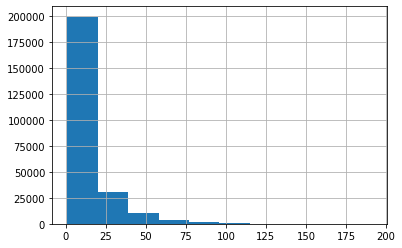

In [ ]:
datetime.datetime(year=2007, month=1, day=1)

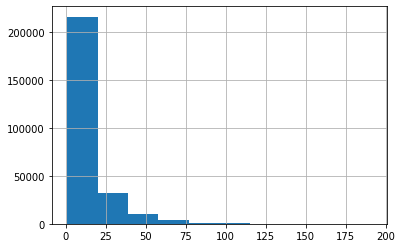

In [ ]:
res_df.fillna(value=datetime.datetime(year=2007, month=1, day=1)).groupby('name').agg({'date' : 'count'}).date.hist()

In [ ]:
qwe = res_df.fillna(value=datetime.datetime(year=2007, month=1, day=1)).groupby('name').agg({'date' : 'count'})

In [ ]:
res_df.name.describe()  # 2483163

count         2483163
unique         263966
top       MARAT TITOV
freq              191
Name: name, dtype: object

In [ ]:
len(qwe[qwe['date'] <= 6])

188189

In [ ]:
qwe.index

Index(['ABRAMOV AL'BERT', 'ABRAMOV ALEKSEI', 'ABRAMOV ALEXEY R',
       'ABRAMOV ANATOLII', 'ABRAMOV ANATOLIY', 'ABRAMOV ANATOLIY M',
       'ABRAMOV ANTON', 'ABRAMOV ARTEM', 'ABRAMOV ARTEM I', 'ABRAMOV ARTEM M',
       ...
       'ZYKOVA VITALINA I', 'ZYKOVA VITALINA P', 'ZYKOVA VITALINA V',
       'ZYKOVA VLADA', 'ZYKOVA VLADA B', 'ZYKOVA VLADISLAVA',
       'ZYKOVA YULIYA G', 'ZYKOVA ZARINA', 'ZYKOVA ZLATA', 'ZYKOVA ZLATA D'],
      dtype='object', name='name', length=263966)

In [ ]:
filtered_df = res_df[res_df.name.isin(qwe[qwe['date'] > 2])]

In [ ]:
filtered_df.airport_from.isna()

148047

In [ ]:
qwe = filtered_df.groupby('flight_number').count()
qwe[qwe.name < 2]

,name,date,city_from,airport_from,city_to,airport_to,fare
flight_number,,,,,,,
AF3568,1,1,1,1,1,1,0
AF3597,1,1,1,1,1,1,0
AF3617,1,1,1,1,1,1,0
AF3627,1,1,1,1,1,1,0
AF3631,1,1,1,1,1,1,0
...,...,...,...,...,...,...,...
MU9916,1,1,1,1,1,1,0
SV1806,1,1,1,1,1,1,0
SV20,1,1,1,1,1,1,0


In [ ]:
filtered_df.flight_number.nunique()

23852

In [ ]:
filtered_df.groupby(['date', 'flight_number']).count().sort_values('name', ascending=False)

name  city_from  ...  airport_to  fare
date       flight_number                   ...                  
2017-01-01 SU1491           56         56  ...          56     0
           VN64             52         52  ...          52     0
           SU4606           47         47  ...          47     0
           SU4600           44         44  ...          44     0
           SU1459           43         43  ...          43     0
...                        ...        ...  ...         ...   ...
2017-06-02 DL2558            1          1  ...           1     0
           DL2480            1          1  ...           1     0
           DL2464            1          1  ...           1     0
           DL2453            1          1  ...           1     0
2018-01-01 VN931             1          1  ...           1     0

[390992 rows x 6 columns]

In [ ]:
res_df.sort_values(by=['flight_number', 'date'])

,name,date,flight_number,city_from,airport_from,city_to,airport_to,fare
300019,ALINA ARTAMONOVA,2017-02-28 00:00:00,AF10,Paris,CDG,New York NY,JFK,NaN
1227034,SEMEN VOROB'EV,2017-03-05 00:00:00,AF10,Paris,CDG,New York NY,JFK,NaN
1090678,YURIY KOLESNIKOV,2017-04-12 00:00:00,AF10,Paris,CDG,New York NY,JFK,NaN
896039,ALEXEY KASATKIN,2017-05-21 00:00:00,AF10,Paris,CDG,New York NY,JFK,NaN
636727,ROSTISLAV BYCHKOV,2017-05-26 00:00:00,AF10,Paris,CDG,New York NY,JFK,NaN
...,...,...,...,...,...,...,...,...
444799,SAMIR NIKULIN,2018-01-01 23:35:00,NaN,PARIS,CDG,RIO DE JANEIRO,GIG,Y
444828,IAROMIR BASHIROV,2018-01-01 23:35:00,NaN,ROME,FCO,MOSCOW,SVO,Y
444998,SHISHKINA AMINA,2018-01-01 23:50:00,NaN,JEDDAH,JED,CASABLANCA,CMN,P
443982,YAN L PAVLOVSKIY,2018-01-01 23:55:00,NaN,SAINT PETERSBURG,LED,MOSCOW,SVO,Y


In [ ]:
res_df[res_df.name == 'MARAT TITOV'].sort_values(by=['name', 'date'])

,name,date,flight_number,city_from,airport_from,city_to,airport_to,fare
458649,MARAT TITOV,2017-01-06 00:00:00,SU5652,Khabarovsk,KHV,Irkutsk,IKT,NaN
113442,MARAT TITOV,2017-01-06 00:00:00,NaN,NaN,VOZ,NaN,SVO,YFLXTY
128697,MARAT TITOV,2017-01-06 00:00:00,NaN,NaN,KHV,NaN,IKT,YGRPJO
277718,MARAT TITOV,2017-01-06 21:40:00,NaN,KHABAROVSK,KHV,IRKUTSK,IKT,Y
458654,MARAT TITOV,2017-01-09 00:00:00,SU1441,Irkutsk,IKT,Moscow,SVO,NaN
...,...,...,...,...,...,...,...,...
96596,MARAT TITOV,NaT,SU1491,NaN,NaN,Moscow,NaN,NaN
125781,MARAT TITOV,NaT,SU1373,NaN,NaN,Moscow,NaN,NaN
128460,MARAT TITOV,NaT,SU1441,NaN,NaN,Moscow,NaN,NaN
131320,MARAT TITOV,NaT,SU1162,NaN,NaN,Rostov,NaN,NaN


## Тест гипотез

In [ ]:
sirena_exp_df.PaxAdditionalInfo.unique()  # можно отсечь с младенцами

array(['S', '9', 'F', '#', nan, '8', '7', '2', 'Assistance Required6',
       '6', '4', 'Assistance Required2', 'E', 'Assistance RequiredF', '0',
       '3', 'Assistance Required', '1', 'Assistance Required#', 'U', 'K',
       '5', 'D', 'Travel with infant', 'B', 'Assistance Required3', 'T',
       'Travel with infant2', 'Travel with infantF',
       'Travel with infant9', 'Assistance Required7',
       'Assistance Required4', 'Assistance Required1',
       'Assistance RequiredB', 'Assistance Required8',
       'Assistance RequiredU', 'Travel with infant#',
       'Travel with infant3', 'Assistance Required9',
       'Assistance Required5', 'Assistance Required0',
       'Assistance RequiredS', 'Assistance RequiredD',
       'Assistance RequiredE', 'Travel with infant6',
       'Assistance RequiredK', 'Travel with infant4',
       'Travel with infant0', 'Assistance RequiredT',
       'Travel with infant8', 'Travel with infantD',
       'Travel with infant5', 'Travel with infantS',
    

In [ ]:
sum(sirena_exp_df.PaxAdditionalInfo == 'Assistance Required7')

84

In [ ]:
c = sirena_exp_df[(
              (sirena_exp_df.PaxAdditionalInfo.str.startswith('Assistance Required')) |
              (sirena_exp_df.PaxAdditionalInfo.str.startswith('Travel with infant'))
              )].card

In [ ]:
sirena_exp_df['card'].dropna()

0          FF 38116280
1         FF 284903754
3         FF 884556993
4         FF 183142068
5         FF 553284496
              ...     
155736    FF 331396957
155742    FF 724472352
155753    FF 261604825
155754    FF 902862806
155756    FF 520710243
Name: card, Length: 51917, dtype: object

In [ ]:
z.apply(translit, language_code='ru', reversed = True).str.upper().apply(lambda x: ' '.join(x.split()[-2::-1]))

0               IL'DAR OZEROV
1               SAMIR KOLOSOV
2           SNEZHANA IGNATOVA
3               PLATON ZHAROV
4          NIKOLAJ NIKOL'SKIJ
                 ...         
155752    MIROSLAV EMEL'JANOV
155753        ARTEMIJ TARASOV
155754          BORIS GOROHOV
155755        RAMIL' DOROFEEV
155756    VARVARA SHAPOVALOVA
Name: PaxName, Length: 155757, dtype: object

In [ ]:
# sk_exchange_df.fare.isin(['FORFAIT', 'IT']))

SyntaxError: ignored

In [ ]:
sk_exchange_df.fare.unique()

In [ ]:
sk_exchange_df[sk_exchange_df.flight=CZ4301]

In [ ]:
point_agg_df[point_agg_df]

In [ ]:
board_pass_df['date'] = pd.to_datetime(board_pass_df['date'])

In [ ]:
board_pass_df.merge(point_agg_df, left_on=['name', 'date'], 
                    right_on = [point_agg_df['first_name'] + ' ' + point_agg_df['last_name'],
                                'activity_date']).head()

In [ ]:
point_agg_df.activity_date

In [ ]:
pd.to_datetime(board_pass_df.date)

In [ ]:
sk_timetable_df.Flight

0         KL1328
1         KL1334
2         KL1336
3         KL1336
4         KL1336
           ...  
212006    CZ6702
212007    MF8540
212008    MF8544
212009    MF8539
212010    MF8543
Name: Flight, Length: 212011, dtype: object

In [ ]:
sk_timetable_df.columns

Index(['Validity', 'Days', 'Dep_Time', 'Arr_Time', 'Flight', 'Aircraft',
       'Travel_Time', 'city_from', 'country_from', 'airport_from', 'city_to',
       'country_to', 'airport_to'],
      dtype='object')

# Сизифов труд

In [ ]:
date_time_str = '18 Nov 19'

date_time_obj = datetime.strptime(date_time_str, '%d %b %y')


print( "The type of the date is now",  type(date_time_obj))
print( "The date is", date_time_obj)

In [ ]:
res_with_fligts_df = res_df.merge(sk_timetable_df, left_on=['city_from', 'city_to','airport_from','airport_to'], 
                    right_on = ['city_from', 'city_to','airport_from','airport_to'])
res_with_fligts_df = res_with_fligts_df.drop(columns=[ 'Days', 'Dep_Time', 'Arr_Time',
        'Travel_Time', 'country_from', 'country_to'])

In [ ]:
def get_fly_try(x):
    try:
        x = x.replace('.1', '')
        a = datetime.datetime.strptime(f'{x.split("-")[0]} 17', '%d %b %y')
        b = datetime.datetime.strptime(f'{x.split("-")[1]} 17', ' %d %b %y')
        if a > b:
            b = datetime.datetime.strptime(f'{x.split("-")[1]} 18', ' %d %b %y')
        q = {'start_flight': a,
             'end_flight': b}
    except Exception as e:

        print(f'{e}  with {x}')
        q = datetime.datetime(year=1092, day=1, month=1)
        q = datetime.datetime(year=1092, day=1, month=1)
        q = {'start_flight': q,
             'end_flight': q}
    return q

In [ ]:
qwe = res_with_fligts_df.Validity.apply(get_fly_try)

In [ ]:
temp = pd.DataFrame(list(qwe))

In [ ]:
pd.concat([sk_timetable_df, temp], axis=1)

,Validity,Days,Dep_Time,Arr_Time,Flight,Aircraft,Travel_Time,city_from,country_from,airport_from,city_to,country_to,airport_to,start_flight,end_flight
0,01 Nov - 31 Jan,1234567,06:00,07:25,KL1328,73W,1H25M,Aalborg,Denmark,AA,Amsterdam,Netherlands,AMS,2018-11-03 00:00:00,2018-01-26 00:00:00
1,01 Nov - 31 Jan,1234567,12:10,13:35,KL1334,73W,1H25M,Aalborg,Denmark,AA,Amsterdam,Netherlands,AMS,2018-11-06 00:00:00,2018-01-15 00:00:00
2,01 Nov - 23 Dec,1234567,18:15,19:35,KL1336,EQV,1H20M,Aalborg,Denmark,AA,Amsterdam,Netherlands,AMS,2018-11-03 00:00:00,2018-01-26 00:00:00
3,26 Dec - 06 Jan,1 34567,18:15,19:35,KL1336,EQV,1H20M,Aalborg,Denmark,AA,Amsterdam,Netherlands,AMS,2018-11-06 00:00:00,2018-01-15 00:00:00
4,07 Jan - 31 Jan,1234567,18:15,19:35,KL1336,EQV,1H20M,Aalborg,Denmark,AA,Amsterdam,Netherlands,AMS,2018-11-03 00:00:00,2018-01-26 00:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
212006,01 Nov - 31 Jan,5,17:30,19:10,CZ6702,EQV,1H40M,Lianyungang,China,LY,Zhoushan,China,HSN,NaN,NaN
212007,01 Nov - 31 Jan,1234567,09:15,10:50,MF8540,738,1H35M,Zhoushan,China,HSN,Quanzhou,China,JJN,NaN,NaN
212008,01 Nov - 31 Jan,1234567,10:15,11:50,MF8544,738,1H35M,Zhoushan,China,HSN,Quanzhou,China,JJN,NaN,NaN
212009,01 Nov - 31 Jan,1234567,06:50,08:15,MF8539,738,1H25M,Quanzhou,China,JJN,Zhoushan,China,HSN,NaN,NaN
